In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [4]:
path_alvo = '../data/processed/target_variable_daily.parquet'
df_alvo = pd.read_parquet(path_alvo)

print(f"Tabela de Alvo carregada com {df_alvo.shape[0]} registros diários.")

Tabela de Alvo carregada com 6827 registros diários.


In [6]:
try:
    path_verificada = '../data/carga_verificada_go.parquet'
    path_programada = '../data/carga_programada_go.parquet'
    df_verificada_raw = pd.read_parquet(path_verificada)
    df_programada_raw = pd.read_parquet(path_programada)
    print("Dados de carga carregados com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivos de carga não encontrados.")
    print("Por favor, execute o script 'scripts/extract_carga_api.py' primeiro.")
    # Interrompe a execução se os arquivos não existirem
    raise

Dados de carga carregados com sucesso.


In [7]:
df_verificada = df_verificada_raw[['din_referenciautc', 'val_cargaglobal']].copy()
df_verificada.rename(columns={'din_referenciautc': 'timestamp', 'val_cargaglobal': 'verificada'}, inplace=True)
df_verificada['timestamp'] = pd.to_datetime(df_verificada['timestamp'])
df_verificada.set_index('timestamp', inplace=True)

df_programada = df_programada_raw[['din_referenciautc', 'val_cargaglobalprogramada']].copy()
df_programada.rename(columns={'din_referenciautc': 'timestamp', 'val_cargaglobalprogramada': 'programada'}, inplace=True)
df_programada['timestamp'] = pd.to_datetime(df_programada['timestamp'])
df_programada.set_index('timestamp', inplace=True)

# Agrega os dados por dia (somando os valores semi-horários)
df_verificada_diaria = df_verificada.resample('D').sum()
df_programada_diaria = df_programada.resample('D').sum()

# Junta os dois dataframes de carga
df_carga_diaria = df_programada_diaria.join(df_verificada_diaria, how='inner')

# Cria a feature de diferença (Verificada - Programada)
df_carga_diaria['diferenca_verif_prog'] = df_carga_diaria['verificada'] - df_carga_diaria['programada']

print("Dados de carga processados e agregados por dia.")
display(df_carga_diaria.head())

Dados de carga processados e agregados por dia.


,programada,verificada,diferenca_verif_prog
timestamp,,,
2023-01-01 00:00:00+00:00,55880.9712,59600.4950,3719.5238
2023-01-02 00:00:00+00:00,75755.3677,85261.9366,9506.5689
2023-01-03 00:00:00+00:00,77425.5065,87493.3420,10067.8355
2023-01-04 00:00:00+00:00,79302.0107,86838.6479,7536.6372
2023-01-05 00:00:00+00:00,79123.4357,83777.6296,4654.1939


In [9]:
# --- 4. Junção (Merge) da Tabela Alvo com as Features de Carga ---

# ANTES DE JUNTAR: Vamos remover a informação de fuso horário do índice da tabela de carga.
# Isso torna os dois índices "tz-naive" e compatíveis para a junção.
df_carga_diaria.index = df_carga_diaria.index.tz_localize(None)


# Agora, com os índices alinhados, a junção irá funcionar sem erros.
df_combinado = df_alvo.join(df_carga_diaria)

# Remover dias para os quais não temos dados de carga (se houver)
df_combinado.dropna(inplace=True)

print("Tabela final combinada (Alvo + Features de Carga):")
display(df_combinado.head())

Tabela final combinada (Alvo + Features de Carga):


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog
timestamp,,,,,
2023-01-01,0.000000,baixo,55880.9712,59600.4950,3719.5238
2023-01-02,0.266667,baixo,75755.3677,85261.9366,9506.5689
2023-01-03,0.000000,baixo,77425.5065,87493.3420,10067.8355
2023-01-04,0.000000,baixo,79302.0107,86838.6479,7536.6372
2023-01-05,0.000000,baixo,79123.4357,83777.6296,4654.1939



Analisando a distribuição das classes de risco:
nivel_risco
baixo    365
medio      1
Name: count, dtype: int64


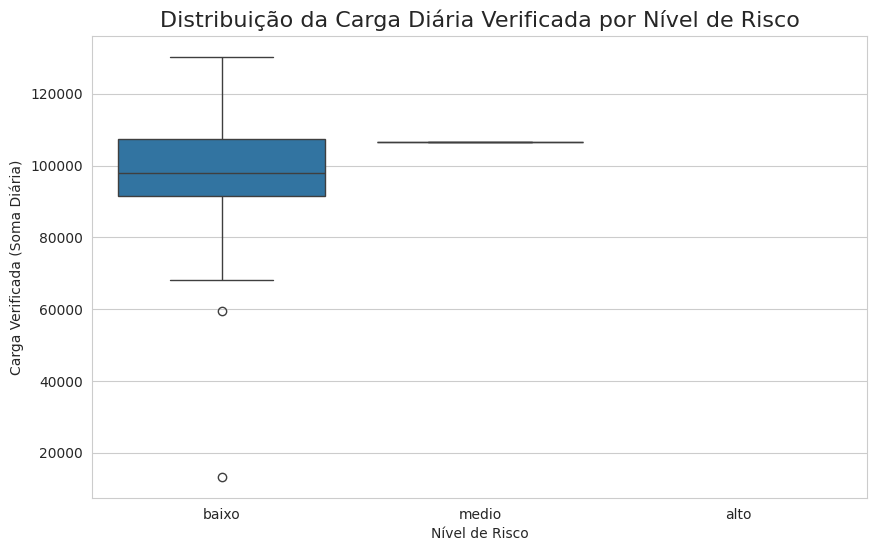

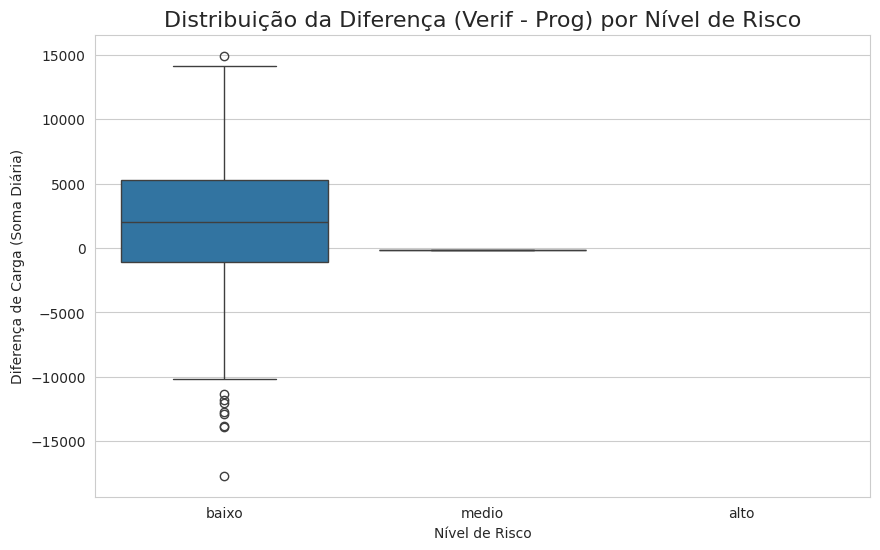

In [10]:
# --- 5. Análise Combinada: Relação entre Features e Alvo ---

print("\nAnalisando a distribuição das classes de risco:")
print(df_combinado['nivel_risco'].value_counts())

# Gráfico 1: Distribuição da carga verificada por nível de risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='verificada', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Distribuição da Carga Diária Verificada por Nível de Risco', fontsize=16)
plt.ylabel('Carga Verificada (Soma Diária)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Distribuição da diferença por nível de risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='diferenca_verif_prog', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Distribuição da Diferença (Verif - Prog) por Nível de Risco', fontsize=16)
plt.ylabel('Diferença de Carga (Soma Diária)')
plt.xlabel('Nível de Risco')
plt.show()

In [11]:
# --- 6. Salvar a Tabela de Features Atualizada ---

# Define e cria o diretório de saída se não existir
output_path = '../data/processed/feature_table_v1.parquet'
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Salva a tabela combinada, que será a base para o próximo notebook
df_combinado.to_parquet(output_path)

print(f"\nTabela de features combinada salva com sucesso em: {output_path}")


Tabela de features combinada salva com sucesso em: ../data/processed/feature_table_v1.parquet
